In [76]:
# Fetch the dataset from the csv using Pandas
import pandas as pd
import numpy as np

#list of columns to be read from the csv for the data part
# names = ["Pregnancies", "Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age"] 

dataset = pd.read_csv("diabetes.csv")
#shuffle the dataset
dataset = dataset.sample(frac = 1.0)

#training split (90% - 70% and 20% split further for train and val)
dataset_train = dataset.sample(frac = 1.0)
dataset_test = dataset[~dataset.index.isin(dataset_train.index)]

# Get the X
X_train = dataset_train.iloc[:, 0:8].values
X_test = dataset_test.iloc[:, 0:8].values

#Get the labels
Y_train = dataset_train.iloc[:, 8].values
Y_test = dataset_test.iloc[:, 8].values

print(dataset_train.shape)
# print(dataset_test.shape)


(768, 9)


In [77]:
# This function is used to convert the binary array into the corresponding decimal value using basic binary to decimal conversion. This is used to convert the af, hd1 and hd2 binary arrays to their corresponding decimal value
def binary_to_decimal(bin_str):
    dec_value = 0

    num_bits = 0 #stores the position of bit from right
    for bit in reversed(bin_str):
        if bit == 1:
            dec_value = dec_value + 2**num_bits
        num_bits = num_bits + 1
    
    return dec_value #return the decimal value of the binary array

# binary_to_decimal([0, 1, 1])


In [78]:
#This function is used to convert the value of alpha from array to the float value using binary to decimal conversion with bits treated as after decimal.
def alpha_value(alpha):
    #Stores the value of the learning rate in form of float
    lr = 0.0

    num_bits = 3
    for i in range(len(alpha)):
        #if the value of alpha at position i is 1 then we can add the value to lr
        if alpha[i] == 1:
            lr = lr + (1/(2**num_bits)) #add the value as 1/2^r where r is the bit position from left
        num_bits = num_bits + 1

    return lr #return the value of the learning rate

# alpha_value([1, 0, 0, 1])


In [79]:
#This function is used to split the chromosome into the lying components of the neural network. In general we will work on the chromosome as a whole, however for verifying and training we need the values of each component separately and thus, this returns all the components in form of list.
def split_chromosome(chromosome):
    #Length of the chromosome has to be 16
    assert len(chromosome) == 16

    alpha = chromosome[0:4] #alpha is the first 4 bits
    af = chromosome[4:6] #activation function is the next 2 bits
    hd1 = chromosome[6:11] #number of hidden neurons in hidden layer 1 are the next 5 bits
    hd2 = chromosome[11:16] #number of hidden neurons in hidden layer 2 are the next 5 bits

    return (alpha, af, hd1, hd2)

# print(split_chromosome([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]))

In [80]:
#function to verify if the chromosome is valid or not. Returns true if valid, ekse false
def verify_chromosome(chromo):
    #split the chromosome into the integer arrays for each component
    lr, af, hd1, hd2 = split_chromosome(chromo)

    #check the values of the components if satisfy the constraints.
    if alpha_value(lr) <= 0.0 or alpha_value(lr) >= 1.0:
        return False
    if binary_to_decimal(hd1) < 2:
        return False
    return True   #return True

In [81]:
#generate_chromosome is responsible to generate a chromosome and sends true if the chromosome generated is a valid one (satisfies all the constraints) and false in case of invalid chromosome
def generate_chromosome(chromo_size):
    #generate the chromosome of size chromo_size with values between 0 or 1
    chromo = [np.random.randint(0, 2) for i in range(chromo_size)]

    flag = verify_chromosome(chromo)

    if flag:
        return (chromo, True)
    return (chromo, False)

# generate_chromosome(16)


In [82]:
#Initial_Population is used to generate the initial population of size 30. The pop is generated by randomly setting each value as 0 or 1 for the 16 indices. We will also verify the value of each component simultaneously to ensure that all the components are in the constrains to be satisfied. This function returns a list of list of size (pop_size, chromosome_size)
def Initial_Population(pop_size, chromo_size):

    #Initialize the population variable as a list of lists of size (30, 16)
    pop = [[int() for i in range(chromo_size)] for j in range(pop_size)] 

    for i in range(pop_size):
        #set the flag as false
        flag = False

        while not flag:
            #get the values of the chromosome and flag from the function. If flag becomes true then the while loop stops and generates no more chromosomes.
            pop[i], flag = generate_chromosome(chromo_size)
    
    return pop

# Initial_Population(30, 16)



In [83]:
# Dictionary for mapping the activation functions to the integer values
int_af = {}

int_af[0] = 'relu'
int_af[1] = 'tanh'
int_af[2] = 'sigmoid'
int_af[3] = 'selu'

In [84]:
#import the dependencies
import keras
import tensorflow
from tensorflow.keras.initializers import GlorotUniform as glorot_uniform
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Sequential

#Train_model is used to train the model and return the loss after the training. For this, first convert the input chromosome into it's components by splitting the chromosome into the values and then constructing the neural network and then training for the number of epochs = 25.
input_shape = X_train.shape #input shape
classes = 1 #consist of only 1 label true or false

#EarlyStopping callback
earlystop = tensorflow.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, verbose = 0)

def Train_model(chromo, num_epochs = 100):


    #split the chromosome into the components
    lr, af, hd1, hd2 = split_chromosome(chromo)

    alpha = alpha_value(lr) #convert the integer array to the float value
    act_func = int_af[binary_to_decimal(af)] #get the activation function string using the map
    h1 = binary_to_decimal(hd1) #number of hidden neurons layer 1
    h2 = binary_to_decimal(hd2) #number of hidden neurons layer 2

    #Construct the model
    model = Sequential()

    #first hidden layer
    model.add(Dense(h1, input_shape = (input_shape[1],), activation = act_func))

    #second hidden layer
    if not(h2 == 0):
        model.add(Dense(h2, activation = act_func))

    #output layer
    model.add(Dense(classes, activation = 'sigmoid'))
    
    #Optimizer used for the training
    opt = keras.optimizers.Adam(learning_rate = alpha)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', 'mse'])

    #call the fit method to perform the training. Store the history used to get the lossesx
    history = model.fit(x = X_train, y = Y_train, epochs = num_epochs, verbose = 0, batch_size = 1024, validation_split = 0.2, callbacks = [earlystop])

    #Training Loss and Accuracy
    losses = history.history['mse']
    accuracy = history.history['accuracy']

    #Validation Loss and Accuracy
    val_losses = history.history['val_mse']
    val_accuracy = history.history['val_accuracy']

    #return the mn loss
    return (np.min(losses), np.max(accuracy), np.min(val_losses), np.max(val_accuracy))

# print(Train_model([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0]))


In [85]:
#assign_area is used to convert the fitness values to area in the roulette wheel to be used to perform the selection of 2 parents for crossover. It returns the area array
def assign_area(fitness, pop_size):
    #store the area for the chromosomes
    area = [float() for j in range(pop_size)]

    sum = 0.0 #sum of all the values
    for x in fitness:
        sum = sum + x
    
    #assign the area array
    for i in range(pop_size):
        area[i] = fitness[i]/sum
    
    return area

In [86]:
#selection is used to perform selection of 2 distinct parents to perform crossover on in order to generate the new offsprings
def selection(area, pop_size):
    #Both the parents are initially -1
    p1, p2 = -1, -1

    count = 0 #while the count does not become equal to 2 we will keep on finding the parents
    while not(count == 2):
        pointer = np.random.rand() #generate a random number between 0 and 1

        sum = 0.0
        i = -1
        while sum < pointer and i < pop_size:
            i = i + 1
            sum =  sum + area[i] #cumulative probability
        
        #First index not found
        if p1 == -1: 
            p1 = i
            count = count + 1
        elif p2 == -1 and not(p1 == p2): #first index found and second not found
            p2 = i
            count = count + 1
    
    return (p1, p2) #return the two parents


In [87]:
#crossover is used to perform two-point crossover on the selected parents. This also ensures that the generated offsprings are valid chromosomes and will keep on performing crossover till we get valid chromosomes. Takes as argument the two parents
def crossover(p1, p2, chromo_size, cross_prob):

    cross_rate = np.random.rand() #if the prob is greater than the cross_prob then we won't perform crossover

    if cross_rate <= cross_prob:
        #run an infinite loop which breaks when we get valid offsprings
        while True:
            crossover_point1 = np.random.randint(0, chromo_size) #generate a random index in the chromosome
            crossover_point2 = np.random.randint(0, chromo_size) #generate another random index in the chromosome
            o1 = p1
            o2 = p2
            #crossover when the points are not same
            if not(crossover_point1 == crossover_point2):
                point1, point2 = min(crossover_point1, crossover_point2), max(crossover_point1, crossover_point2) #assign the two points in proper order

                #swap the chrosome in between the crossover points
                o1 = np.concatenate((p2[0:point1], p1[point1:point2], p2[point2:]))
                o2 = np.concatenate((p1[0:point1], p2[point1:point2], p1[point2:]))
            
            assert len(o1) == chromo_size and len(o2) == chromo_size
            
            #if both the chrosomes are valid
            if verify_chromosome(o1) and verify_chromosome(o2):
                return (o1, o2)
    else:
        return (p1, p2)

In [88]:
#mutate is used to perform mutation on the chromosome and will depend on the mut_prob. 
def mutate(chromo, chromo_size, mut_prob):
    chromo_copy = chromo

    #run an infinite loop till the chromosome generated is valid
    while True:
        for i in range(chromo_size):
            mut_rate = np.random.rand() #generate a random number between 0 and 1 to decide whether to perform mutation or not

            if mut_rate <= mut_prob:
                chromo_copy[i] = np.random.randint(0, 2) #give the chromosome bit to 0 or 1
                
        if verify_chromosome(chromo_copy):
            return chromo_copy #return the new chromosome
        else:
            chromo_copy = chromo #reassign the original chromosome

In [89]:
from tqdm.notebook import tqdm as tqdm #for the progress bar

# --------------------------- GENETIC ALGORITHM FUNCTION ---------------------------------
#This function is responsible to handle the entire algorithm. It takes as arguments the population size, chromosome size and the number of generations or number of epochs and returns the minimum loss or maximum fitness for each generation or population.

def genetic_algorithm(pop_size, chromo_size, num_gen):

    # Model Params
    #number of epochs for training
    num_epochs = 100

    #elitism factor
    elitism = 2

    #Crossover probability
    cross_prob = 0.8

    #Mutation probability
    mut_prob = 0.01

    #generate the initial population
    pop = Initial_Population(pop_size, chromo_size)

    #stores the minimum training and validation losses for each generation
    min_val_losses = [float() for i in range(num_gen)]
    min_train_losses = [float() for i in range(num_gen)]

    #stores the maximum training and validation accuracy for each generation
    max_val_acc = [float() for i in range(num_gen)]
    max_train_acc = [float() for i in range(num_gen)]

    #stores the losses for entire generation
    val_losses = [float() for i in range(pop_size)]
    train_losses = [float() for i in range(pop_size)]

    #stores the accuracy for entire generation
    val_accuracy = [float() for i in range(pop_size)]
    train_accuracy = [float() for i in range(pop_size)]

    #stores the fitness for entire generation
    fitness = [float() for i in range(pop_size)]

    #generations completed
    gen_complete = "\tGenerations Completed"

    #Stores the new population
    new_pop = [[] for i in range(pop_size)]
    cur_size = 0 #current size of population

    start = 0

    indices = [] #to store the top 4 individuals
    #run a loop for the number of generations

    #Printing the output properly
    print("Gen. No.\tVal. Error\tTrain Error\tVal. Acc.\tTrain Acc.")

    for i in tqdm(range(num_gen), gen_complete):

        # Train the model for different generations and the metric for fitness is the loss. Lower the loss, higher the fitness
        for j in range(pop_size):
            if(j < start):
                continue
            train_losses[j], train_accuracy[j], val_losses[j], val_accuracy[j] = Train_model(pop[j], num_epochs)

            #fitness is the inverse of the loss.
            fitness[j] = 1.0/val_losses[j]
    
        #Assign area to each chromosome based on the fitness to perform roulette wheel selection
        area = assign_area(fitness, pop_size)

        min_val_losses[i] = np.min(val_losses) #find the min val loss
        min_train_losses[i] = np.min(train_losses) #find the min train loss
        max_val_acc[i] = np.max(val_accuracy) #find the max val accuracy
        max_train_acc[i] = np.max(train_accuracy) #find the max train accuracy

        #Perform elitism by putting the top 4 individuals based on fitness into the new population
        indices = (np.array(val_losses)).argsort()[:elitism]
        for x in indices:
            new_pop[cur_size] = pop[x]

            #save the current state of the best fitness individuals
            train_losses[cur_size] = train_losses[x]
            train_accuracy[cur_size] = train_accuracy[x]
            val_losses[cur_size] = val_losses[x]
            val_accuracy[cur_size] = val_accuracy[x]
            fitness[cur_size] = fitness[x]

            cur_size = cur_size + 1
        
        #do not train the best individuals in next generation
        start = elitism

        #Perform selection using roulette wheel selection for the remaining 22 individuals (11 times selection and crossover) by crossover
        for j in range(int((pop_size-elitism)/2)):
            #select 2 parents
            p1, p2 = selection(area, pop_size)

            #Perform crossover on the selected parents to get 2 offsprings
            o1, o2 = crossover(pop[p1], pop[p2], chromo_size, cross_prob)

            #add the offsprings to the new population
            new_pop[cur_size] = o1
            cur_size = cur_size + 1
            new_pop[cur_size] = o2
            cur_size = cur_size + 1

        #Perform Mutation. We keep the rate of mutation low because if the mutation is high, then it will lead to high diversity and thus late convergence.

        #perform mutation for each chromosome except the chrosomes sent through elitism
        for j in range(start, pop_size):
            new_pop[j] = mutate(new_pop[j], chromo_size, mut_prob)
        
        pop = new_pop #assign the new population to the old population

        cur_size = 0 #reassign the size of next population

        if (i+1)%5 == 0:
            print("{:05d}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(i + 1, min_val_losses[i], min_train_losses[i], max_val_acc[i], max_train_acc[i]))

        assert (len(pop) == pop_size), "Population Error" #assertions to avoid any error

    return (min_train_losses, max_train_acc, min_val_losses, max_val_acc)


		----------- Iteration No. 1 --------------
Gen. No.	Val. Loss	Train Loss	Val. Acc.	Train Acc.


00005		0.2187		0.2141		0.6623		0.6775
00010		0.2107		0.2138		0.6623		0.6938
00015		0.2107		0.2108		0.6688		0.6938
00020		0.2107		0.2138		0.6623		0.6938
00025		0.2107		0.2118		0.6623		0.6938
00030		0.2107		0.2098		0.6623		0.6938

Min Loss = 0.2107, Max Loss = 0.2187, Std Loss = 0.0034
Min Accuracy = 0.6623, Max Accuracy = 0.6948, Std Accuracy = 0.0071


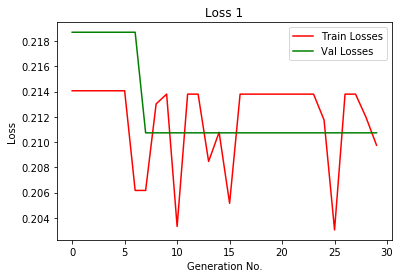

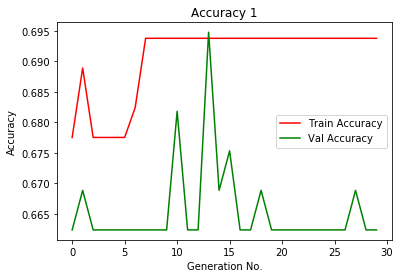

		----------- Iteration No. 2 --------------
Gen. No.	Val. Loss	Train Loss	Val. Acc.	Train Acc.


00005		0.2097		0.2084		0.7078		0.6661
00010		0.2085		0.1975		0.6818		0.6971
00015		0.2085		0.1975		0.6818		0.6971
00020		0.1840		0.1768		0.7338		0.7427
00025		0.1840		0.1768		0.7338		0.7427
00030		0.1840		0.1768		0.7338		0.7427

Min Loss = 0.1840, Max Loss = 0.2097, Std Loss = 0.0125
Min Accuracy = 0.6818, Max Accuracy = 0.7338, Std Accuracy = 0.0207


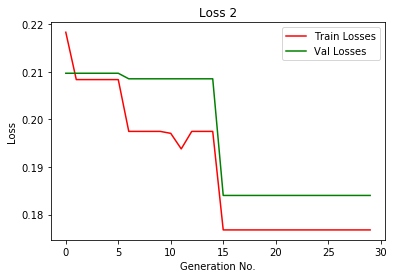

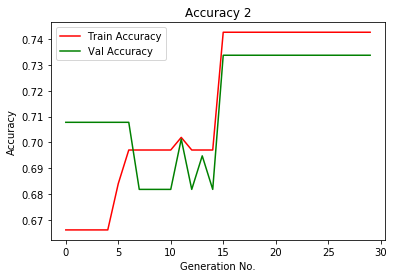

		----------- Iteration No. 3 --------------
Gen. No.	Val. Loss	Train Loss	Val. Acc.	Train Acc.


00005		0.2038		0.1866		0.6818		0.7068
00010		0.2038		0.1866		0.7143		0.7068
00015		0.2038		0.1866		0.6623		0.7068
00020		0.2038		0.1866		0.6883		0.7068
00025		0.2030		0.1866		0.6883		0.7134
00030		0.2030		0.1936		0.6883		0.7134

Min Loss = 0.2030, Max Loss = 0.2253, Std Loss = 0.0055
Min Accuracy = 0.6623, Max Accuracy = 0.7208, Std Accuracy = 0.0164


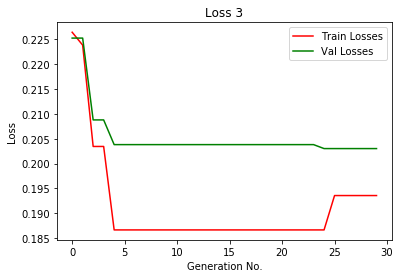

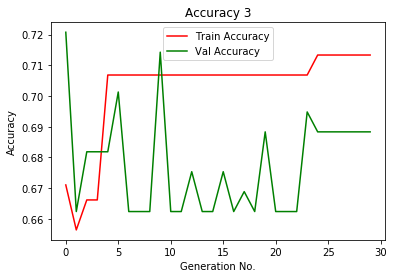

		----------- Iteration No. 4 --------------
Gen. No.	Val. Loss	Train Loss	Val. Acc.	Train Acc.


00005		0.1982		0.1786		0.7208		0.7296
00010		0.1777		0.1571		0.7597		0.7834
00015		0.1777		0.1571		0.7597		0.7834




KeyboardInterrupt: 

In [75]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm #for the progress bar

# ----------------------------- MAIN FUNCTION -----------------------------
# This is responsible to run the genetic algorithm 30 times to get the most optimal result

#population size
pop_size = 10

#chromosome size
chromo_size = 16

#number of generations
num_gen = 30

#We run the genetic algorithm for 30 times and then take the best result from it.
num_iterations = 30

#Stores the results from each iteration
best_loss = [float() for i in range(num_iterations)]

for iter_num in tqdm(range(num_iterations), "Iterations Completed"):

    print("\t\t----------- Iteration No. {} --------------".format(iter_num + 1))
    train_losses, train_acc, val_losses, val_acc = genetic_algorithm(pop_size, chromo_size, num_gen)

    #update the best_loss array
    best_loss[iter_num] = np.min(val_losses)

    print("Min Loss = {:.4f}, Max Loss = {:.4f}, Std Loss = {:.4f}".format(np.min(val_losses), np.max(val_losses), np.std(val_losses)))
    print("Min Accuracy = {:.4f}, Max Accuracy = {:.4f}, Std Accuracy = {:.4f}".format(np.min(val_acc), np.max(val_acc), np.std(val_acc)))

    #Plot the loss vs generation number
    plt.figure(1)
    line1 , = plt.plot(train_losses, color = "red", label = "Train Error")
    line2 , = plt.plot(val_losses, color = "green", label = "Val Error")
    plt.legend(handles=[line1, line2])
    plt.title("Error {}".format(iter_num + 1))
    plt.xlabel("Generation No.")
    plt.ylabel("Error")

    #Plot the accuracy vs generation number
    plt.figure(2)
    line1 , = plt.plot(train_acc, color = "red", label = "Train Accuracy")
    line2 , = plt.plot(val_acc, color = "green", label = "Val Accuracy")
    plt.legend(handles=[line1, line2])
    plt.title("Accuracy {}".format(iter_num + 1))
    plt.xlabel("Generation No.")
    plt.ylabel("Accuracy")
    
    plt.show()

print("The best error is:", np.min(best_loss))